In [1]:
import numpy as np # linear algebra
from numpy import log

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

import math

from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pylab import rcParams

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller #for Stationarity


from sklearn.metrics import mean_absolute_error, mean_squared_error #Error Metrics
import warnings # Supress warnings 
warnings.filterwarnings('ignore')

In [5]:
!pip install pmdarima

In [2]:
import pmdarima as pm # Auto TimeSeries

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

In [4]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
df.info

<bound method DataFrame.info of        Month  #Passengers
0    1949-01          112
1    1949-02          118
2    1949-03          132
3    1949-04          129
4    1949-05          121
..       ...          ...
139  1960-08          606
140  1960-09          508
141  1960-10          461
142  1960-11          390
143  1960-12          432

[144 rows x 2 columns]>

In [6]:
df['Month'] = pd.to_datetime(df['Month'],infer_datetime_format=True)
df = df.set_index(['Month'])
df.head(5)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [7]:
df.rename(columns = {'#Passengers':'Passengers'}, inplace = True)

In [8]:
df.head(5)

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


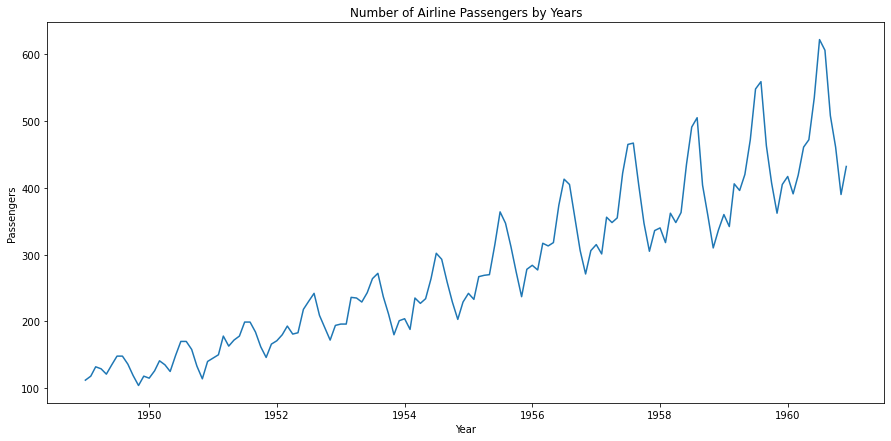

In [9]:
plt.figure(figsize=(15,7))
plt.title("Number of Airline Passengers by Years")
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.plot(df)
plt.show()

In [10]:
df_train = df[:134]
df_test = df[134:]

In [11]:
def stationarity_test(timeseries):
    # Get rolling statistics for window = 12 i.e. yearly statistics
    rolling_mean = timeseries.rolling(window = 12).mean()
    rolling_std = timeseries.rolling(window = 12).std()
    
    # Plot rolling statistic
    plt.figure(figsize= (10,6))
    plt.xlabel('Years')
    plt.ylabel('Open')    
    plt.title('Stationary Test: Rolling Mean and Standard Deviation')
    plt.plot(timeseries, color= 'blue', label= 'Original')
    plt.plot(rolling_mean, color= 'green', label= 'Rolling Mean')
    plt.plot(rolling_std, color= 'red', label= 'Rolling Std')   
    plt.legend()
    plt.show()
    
    # Dickey-Fuller test
    print('Results of Dickey-Fuller Test')
    df_test = adfuller(timeseries)

    df_output = pd.Series(df_test[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in df_test[4].items():
        df_output['Critical Value (%s)' %key] = value
    print(df_output)

    adf = df_test[0]
    pvalue = df_test[1]
    critical_value = df_test[4]['5%']
    if(pvalue < 0.05) and (adf < critical_value):
        print("The Series is STATIONARY")
    else:
        print("The Series is NOT Stationary")

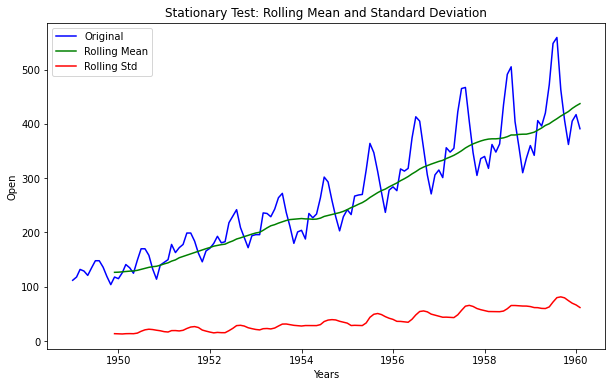

Results of Dickey-Fuller Test
Test Statistic                   0.818516
p-value                          0.991929
#Lags Used                      13.000000
Number of Observations Used    120.000000
Critical Value (1%)             -3.486056
Critical Value (5%)             -2.885943
Critical Value (10%)            -2.579785
dtype: float64
The Series is NOT Stationary


In [12]:
# Lets test the stationarity score with original series data
stationarity_test(df_train)

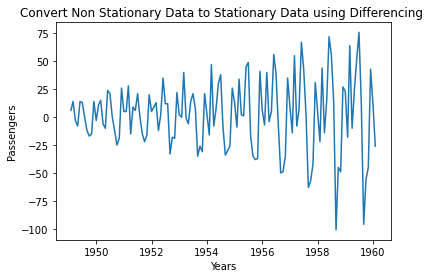

In [13]:
# ### Using Differencing to make data Stationary




df_train_diff = df_train.diff(periods = 1) # First order differencing
plt.xlabel('Years')
plt.ylabel('Passengers')    
plt.title('Convert Non Stationary Data to Stationary Data using Differencing ')
plt.plot(df_train_diff)

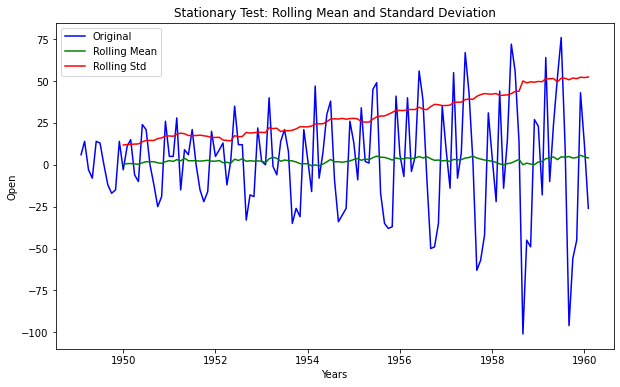

Results of Dickey-Fuller Test
Test Statistic                  -2.737820
p-value                          0.067719
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64
The Series is NOT Stationary


In [14]:
df_train_diff.dropna(inplace = True)# Data transformation may add na values
stationarity_test(df_train_diff)

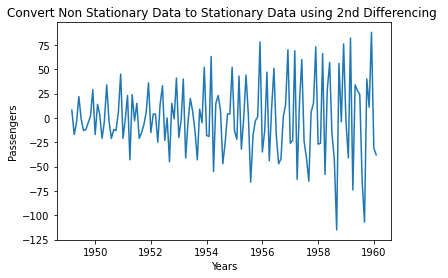

In [15]:
# #### Likewise we can 2nd order differencing(if the data is not stationary in the 1st order differencing)


df_train_diff2 = df_train_diff.diff(periods = 1) # second order differencing
plt.xlabel('Years')
plt.ylabel('Passengers')    
plt.title('Convert Non Stationary Data to Stationary Data using 2nd Differencing ')
plt.plot(df_train_diff2)

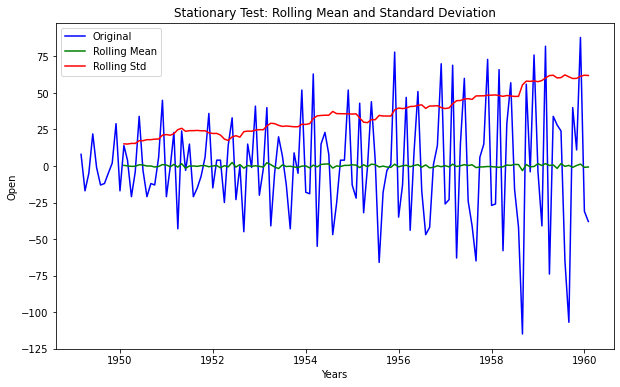

In [16]:
df_train_diff2.dropna(inplace = True)# Data transformation may add na values
stationarity_test(df_train_diff2)

Results of Dickey-Fuller Test
Test Statistic                -1.422054e+01
p-value                        1.660794e-26
#Lags Used                     1.100000e+01
Number of Observations Used    1.200000e+02
Critical Value (1%)           -3.486056e+00
Critical Value (5%)           -2.885943e+00
Critical Value (10%)          -2.579785e+00
dtype: float64
The Series is STATIONARY


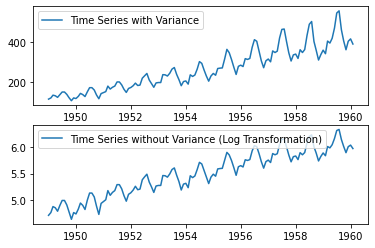

In [17]:
# ### Additionally we can use transformation techniques like Log, exponential etc for smoothing the data.



df_train_log = np.log(df_train)

plt.subplot(211)
plt.plot(df_train, label= 'Time Series with Variance')
plt.legend()
plt.subplot(212)
plt.plot(df_train_log, label='Time Series without Variance (Log Transformation)')
plt.legend()  
plt.show()

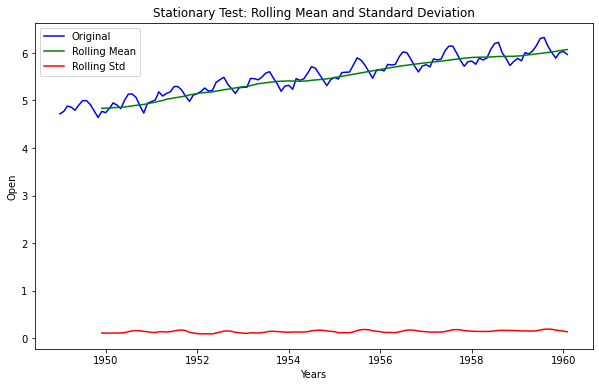

Results of Dickey-Fuller Test
Test Statistic                  -1.449889
p-value                          0.558139
#Lags Used                      13.000000
Number of Observations Used    120.000000
Critical Value (1%)             -3.486056
Critical Value (5%)             -2.885943
Critical Value (10%)            -2.579785
dtype: float64
The Series is NOT Stationary


In [18]:
stationarity_test(df_train_log)

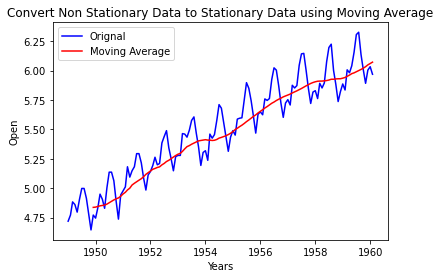

In [19]:
# ### Rolling mean on the log data (Moving Average)




df_train_log_moving_avg = df_train_log.rolling(window = 12).mean()
plt.xlabel('Years')
plt.ylabel('Open')    
plt.title('Convert Non Stationary Data to Stationary Data using Moving Average')
plt.plot(df_train_log, color= 'blue', label='Orignal')
plt.plot(df_train_log_moving_avg, color= 'red', label='Moving Average')
plt.legend()

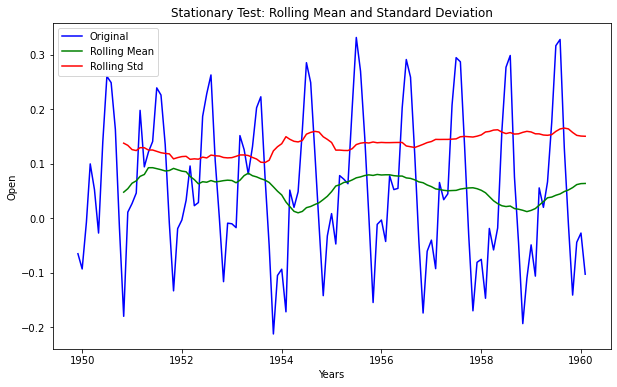

Results of Dickey-Fuller Test
Test Statistic                  -3.087344
p-value                          0.027504
#Lags Used                      13.000000
Number of Observations Used    109.000000
Critical Value (1%)             -3.491818
Critical Value (5%)             -2.888444
Critical Value (10%)            -2.581120
dtype: float64
The Series is STATIONARY


In [20]:
df_train_log_moving_avg_diff = df_train_log - df_train_log_moving_avg
df_train_log_moving_avg_diff.dropna(inplace = True)
stationarity_test(df_train_log_moving_avg_diff)

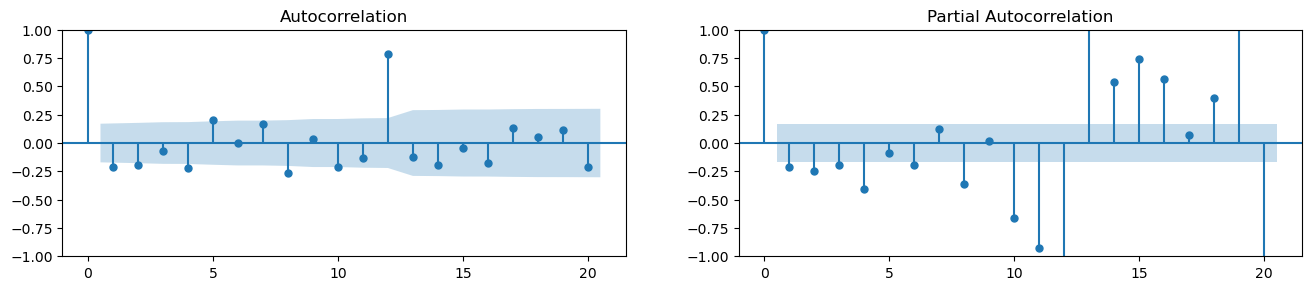

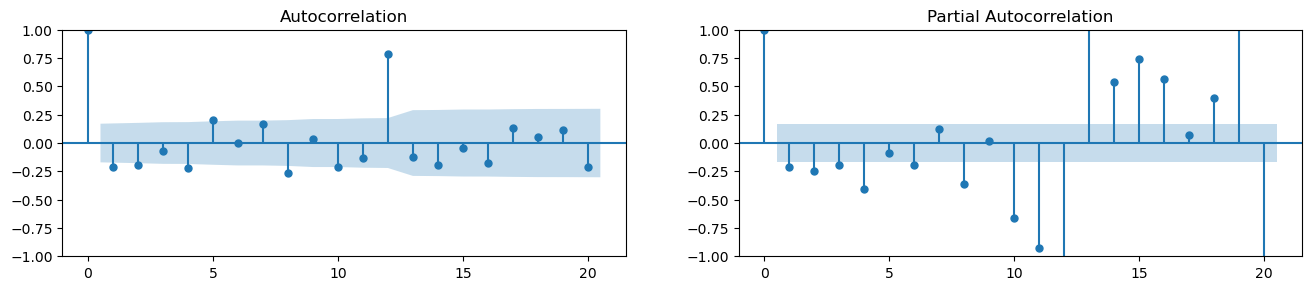

In [21]:

fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df_train_diff2['Passengers'].tolist(), lags=20, ax=axes[0])
plot_pacf(df_train_diff2['Passengers'].tolist(), lags=20, ax=axes[1])

In [22]:
# #### Building ARIMA

# In[20]:


from statsmodels.tsa.arima.model import ARIMA

In [27]:
model1 = ARIMA(df_train, order = (10,2,0)) 
results_ARIMA = model1.fit()
print(results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  134
Model:                ARIMA(10, 2, 0)   Log Likelihood                -597.524
Date:                Tue, 06 Dec 2022   AIC                           1217.049
Time:                        15:36:58   BIC                           1248.759
Sample:                    01-01-1949   HQIC                          1229.934
                         - 02-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3334      0.078     -4.270      0.000      -0.486      -0.180
ar.L2         -0.7553      0.074    -10.248      0.000      -0.900      -0.611
ar.L3         -0.3326      0.071     -4.663      0.0

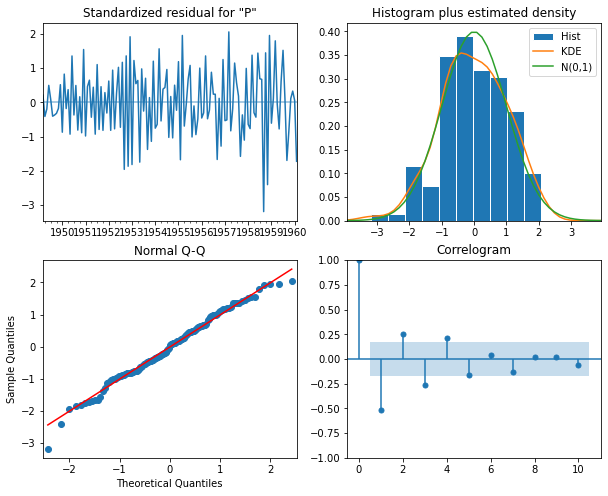

In [28]:
results_ARIMA.plot_diagnostics(figsize=(10,8))
plt.show()

In [29]:
pred = results_ARIMA.predict()


In [30]:
type(pred)


pandas.core.series.Series

In [31]:

pred

1949-01-01      0.000000
1949-02-01    168.025277
1949-03-01    124.025935
1949-04-01    144.509214
1949-05-01    128.152760
                 ...    
1959-10-01    425.314354
1959-11-01    359.587858
1959-12-01    397.934502
1960-01-01    415.807222
1960-02-01    428.317984
Freq: MS, Name: predicted_mean, Length: 134, dtype: float64

In [32]:
pred = pred.to_frame()
pred.head()

,predicted_mean
1949-01-01,0.000000
1949-02-01,168.025277
1949-03-01,124.025935
1949-04-01,144.509214
1949-05-01,128.152760


In [33]:
pred.head(5)



,predicted_mean
1949-01-01,0.000000
1949-02-01,168.025277
1949-03-01,124.025935
1949-04-01,144.509214
1949-05-01,128.152760


In [34]:

pred.tail(5)

,predicted_mean
1959-10-01,425.314354
1959-11-01,359.587858
1959-12-01,397.934502
1960-01-01,415.807222
1960-02-01,428.317984


In [35]:
print("Train MAPE: ",mean_absolute_error(df_train.Passengers,pred.predicted_mean))


Train MAPE:  18.954232282038326


In [36]:
print("Train MSE: ",mean_squared_error(df_train.Passengers,pred.predicted_mean))


Train MSE:  580.4073924817425


In [37]:

from sklearn.metrics import mean_absolute_percentage_error 

In [38]:
print("Train MAPE: ",mean_absolute_percentage_error(df_train.Passengers,pred.predicted_mean))


Train MAPE:  0.08585250149993817


In [39]:
forecast_test = results_ARIMA.forecast(10)


In [40]:
forecast_test = forecast_test.to_frame()
forecast_test.head()

,predicted_mean
1960-03-01,390.620995
1960-04-01,364.714130
1960-05-01,398.999693
1960-06-01,440.440083
1960-07-01,490.780208


In [41]:
print("Test MAPE: ",mean_absolute_percentage_error(df_test.Passengers,forecast_test.predicted_mean))


Test MAPE:  0.1653675286995738


In [42]:
print("Test MSE: ",mean_squared_error(df_test.Passengers,forecast_test.predicted_mean))


Test MSE:  8378.341751158368


Text(0.5, 1.0, 'forecasting the Time Series')

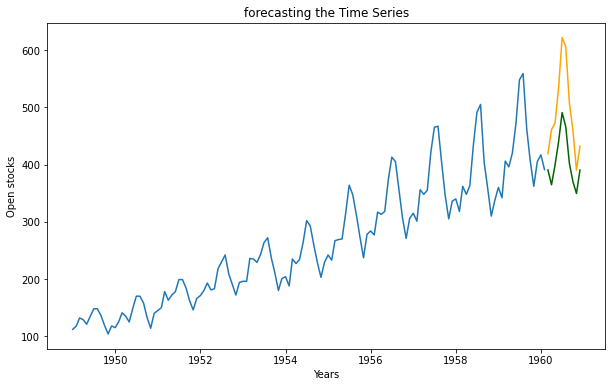

In [43]:
plt.figure(figsize= (10,6))
plt.plot(df_train.Passengers)
plt.plot(df_test.Passengers,color="orange")
plt.plot(forecast_test.predicted_mean,color="darkgreen")
plt.xlabel('Years')
plt.ylabel('Open stocks')
plt.title('forecasting the Time Series')

In [47]:
# #### Auto ARIMA on Train datas


model2 = pm.auto_arima(df_train, 
                      trace=True,
                      )

print(model2.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1241.041, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1295.940, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1286.658, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1282.753, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1294.543, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1275.953, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1245.123, Time=0.32 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 3.911

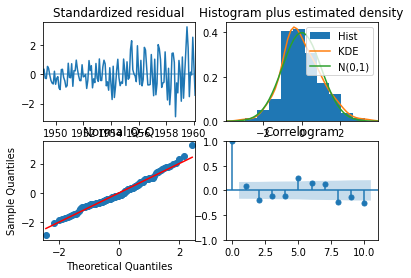

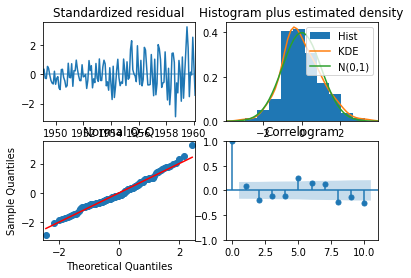

In [48]:
model2.plot_diagnostics()


In [49]:
test_pred_2 = model2.predict()


In [50]:
test_pred_2= test_pred_2.to_frame()
test_pred_2.head()

,0
1960-03-01,414.126091
1960-04-01,444.990215
1960-05-01,475.199126
1960-06-01,497.670861
1960-07-01,508.290426


In [51]:
test_pred_2.rename(columns={0:"Prediction"},inplace=True)


In [52]:
print("Test MAPE on Model2: ", mean_absolute_percentage_error(df_test.Passengers,test_pred_2.Prediction))


Test MAPE on Model2:  0.07756689961416857


In [53]:
print("Test MSE on Model2: ", mean_squared_error(df_test.Passengers,test_pred_2.Prediction))


Test MSE on Model2:  3097.4035461349413


In [54]:
# ###                                   ---------------------------Decomposing

#  In Multiplicative model, we assume that all the components of the time series are dependent and in Additive model it is assumed that the components are independent.

In [55]:

from statsmodels.tsa.seasonal import seasonal_decompose

# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(df['Passengers'], model='multiplicative', period=30)

In [56]:
# Additive Decomposition

additive_decomposition = seasonal_decompose(df['Passengers'], model='additive', period=30)


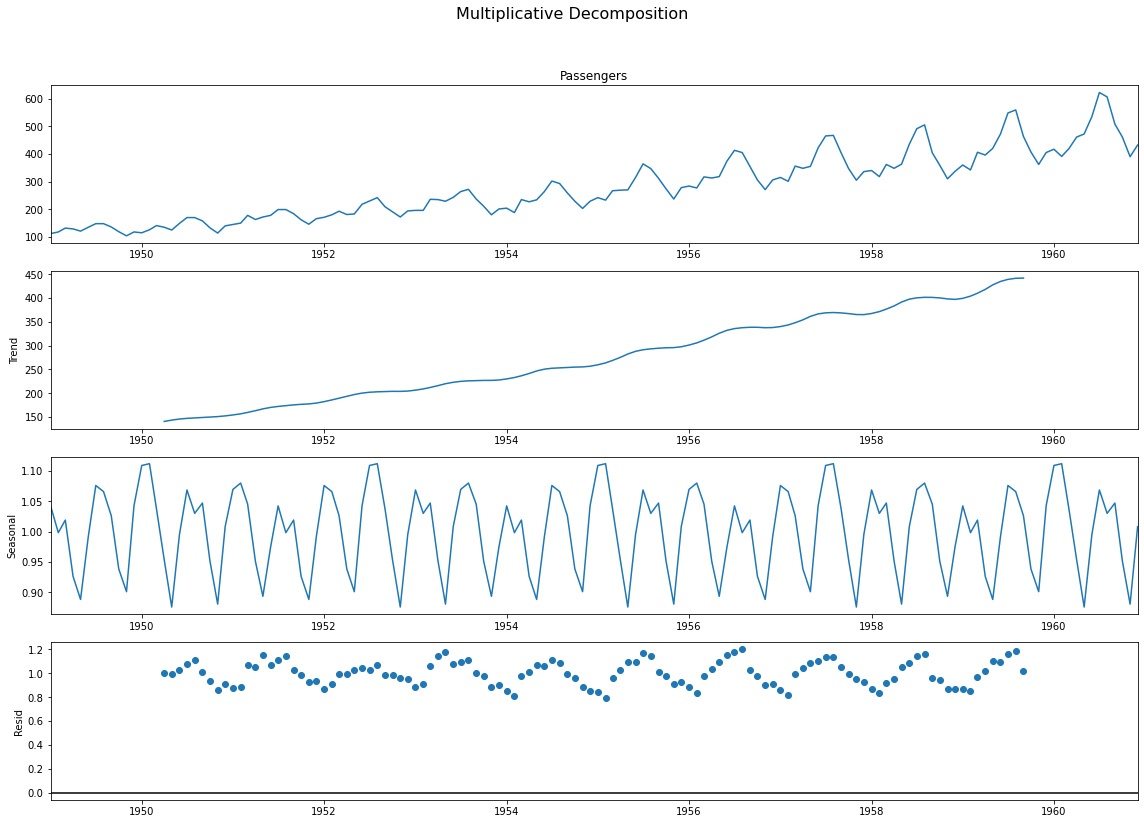

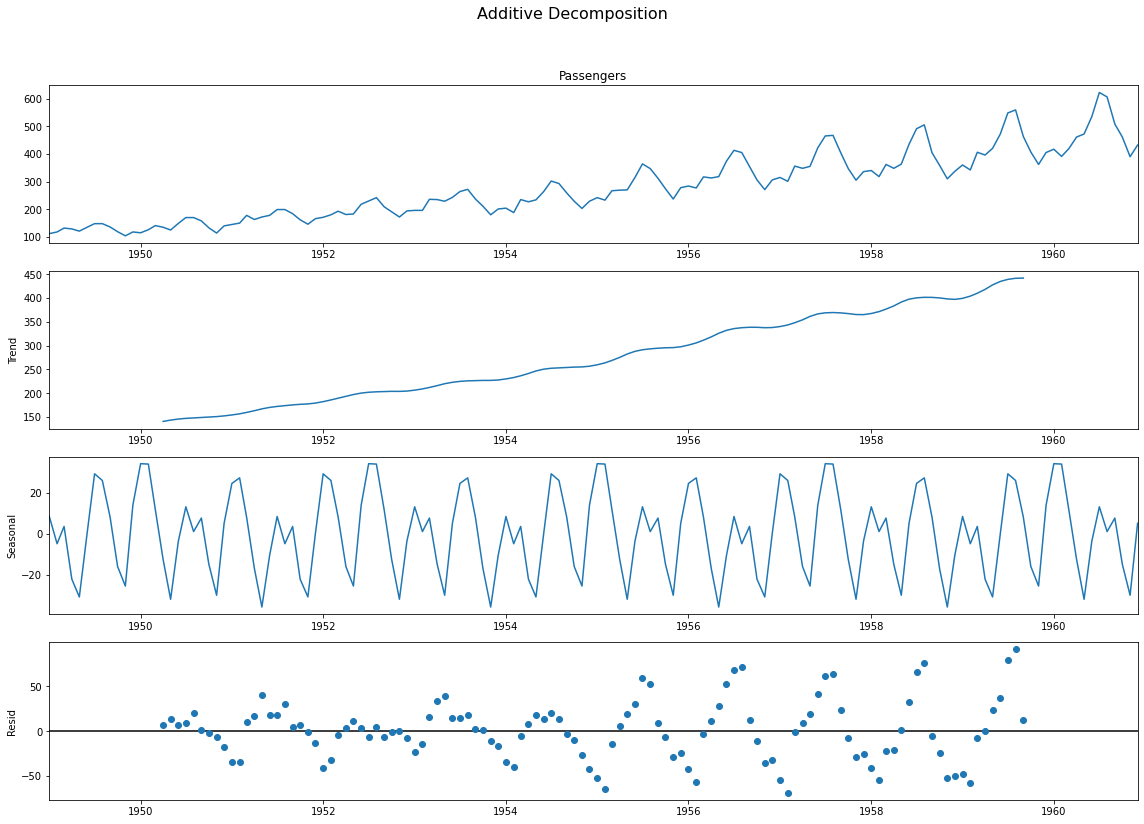

In [57]:
# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

Text(0.5, 1.0, 'Air Passengers detrended ')

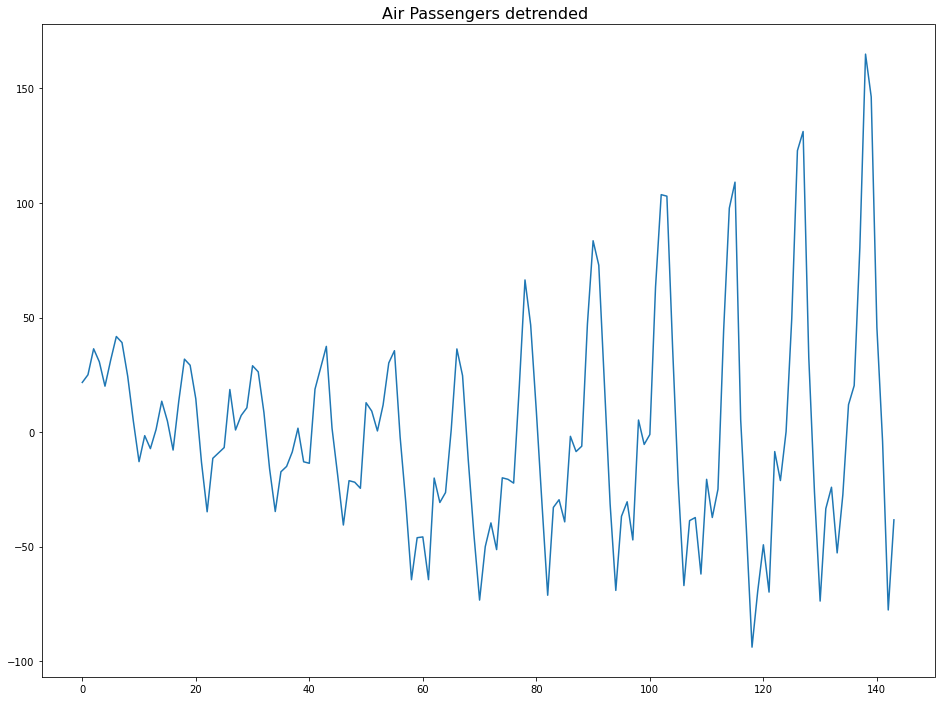

In [58]:
# ### Detrend
# Using scipy: Subtract the line of best fit using least squares
from scipy import signal
detrended = signal.detrend(df['Passengers'].values)
plt.plot(detrended)
plt.title('Air Passengers detrended ', fontsize=16)

In [ ]:
# Using statmodels: Subtracting the Trend Component
from statsmodels.tsa.seasonal import seasonal_decompose
result_mul = seasonal_decompose(df['Passengers'], model='multiplicative', period=30)
detrend = df['Passengers'].values / result_mul.trend
plt.plot(detrend)
plt.title('Air Passengers detrended by subtracting the trend component', fontsize=16)

In [ ]:
# Subtracting the seasonal Component

# Time Series Decomposition
result_mul = seasonal_decompose(df['Passengers'], model='multiplicative', period=30)


# Deseasonalize
deseasonalized = df['Passengers'].values / result_mul.seasonal

# Plot
plt.plot(deseasonalized)
plt.title('Air Passengers Deseasonalized', fontsize=16)
plt.plot()

In [ ]:
# Substracting Seasoanl component
# Time Series Decomposition
result_add = seasonal_decompose(df['Passengers'], model='additive', period=30)

# Deseasonalize
deseasonalized_add = df['Passengers'].values - result_add.seasonal

# Plot
plt.plot(deseasonalized_add)
plt.title('Air Passengers Deseasonalized', fontsize=16)
plt.plot()

In [ ]:
desea_df = deseasonalized.to_frame()


In [ ]:

train_desea = desea_df[:134]
test_desea = desea_df[134:]

In [ ]:
stationarity_test(deseasonalized)


In [ ]:
deseasonalized_diff = deseasonalized.diff(periods = 1) # First order differencing
plt.xlabel('Years')
plt.ylabel('Passengers')    
plt.title('Convert Non Stationary Data to Stationary Data using Differencing on deseasoned data')
plt.plot(deseasonalized_diff)

In [ ]:
deseasonalized_diff.dropna(inplace = True)# Data transformation may add na values

stationarity_test(deseasonalized_diff)

In [ ]:
deseasonalized_diff2 = deseasonalized_diff.diff(periods = 1) # Second order differencing
plt.xlabel('Years')
plt.ylabel('Passengers')    
plt.title('Convert Non Stationary Data to Stationary Data using 2nd order Differencing on deseasoned data')
plt.plot(deseasonalized_diff2)

In [ ]:
deseasonalized_diff2.dropna(inplace = True)# Data transformation may add na values

stationarity_test(deseasonalized_diff2)

In [ ]:
deseasonalized_diff2


In [ ]:
deseasonalized_diff2 = deseasonalized_diff2.to_frame()
deseasonalized_diff2.head()

In [ ]:
# #### Auto ARIMA On Decomposed Multiplicative data




model_3 = pm.auto_arima(train_desea,trace=True)
print(model_3.summary())

In [ ]:
model_3.plot_diagnostics()


In [ ]:
pred_test_sea_3 = model_3.predict()


In [ ]:
pred_test_sea_3 = pred_test_sea_3.to_frame()
pred_test_sea_3.head()

In [ ]:
pred_test_sea_3.rename(columns={0:"Prediction"},inplace=True)


In [ ]:
print("Test MAPE : ",mean_absolute_percentage_error(test_desea.seasonal,pred_test_sea_3.Prediction)) #without Seasonality component to predictions

In [ ]:
print("Train MSE : ",mean_squared_error(test_desea.seasonal,pred_test_sea_3.Prediction)) #without Seasonality component to predictions
